### Setup Environment:

In [1]:
import pandas as pd
import os

import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score
from sklearn.preprocessing import MultiLabelBinarizer

# Function to train classic ML model
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt

In [4]:
PATH = 'Embeddings/fakeddit/'
COLUMN = 'embeddings'

In [5]:
text_path, images_path = os.listdir(PATH)

## Get data

### Text

In [6]:
text = pd.read_csv(os.path.join(PATH, text_path))
text

,image,class,split,ingredients,embeddings
0,onion_rings/0_einkorn_onion_rings_hostedLargeU...,onion_rings,val,"yellow onion,flour,baking powder,seasoning sal...","[1.1028140783309937, -1.5013680458068848, -0.3..."
1,onion_rings/1_crispy_onion_rings_hostedLargeUr...,onion_rings,train,"white onion,panko,cornmeal,ground paprika,onio...","[0.2510446310043335, -0.8487659692764282, -0.7..."
2,onion_rings/2_onion_rings_hostedLargeUrl.jpg,onion_rings,train,"yellow onion,all-purpose flour,baking powder,l...","[0.6824526786804199, -1.090896487236023, 0.987..."
3,onion_rings/3_onion_rings_hostedLargeUrl.jpg,onion_rings,train,"oil,pancake mix,spanish onion","[2.3841049671173096, -5.021180629730225, -0.17..."
4,onion_rings/4_onion_rings_hostedLargeUrl.jpg,onion_rings,train,"peanut oil,sweet onion,flour,eggs,celery salt,...","[2.3817403316497803, 0.37943604588508606, -3.5..."
...,...,...,...,...,...
4821,chocolate_ice_cream/45_chocolate_ice_cream_hos...,chocolate_ice_cream,train,"dark chocolate,whole milk,unsweetened cocoa po...","[1.4988073110580444, -0.4912002980709076, 1.06..."
4822,chocolate_ice_cream/46_dark_chocolate_ice_crea...,chocolate_ice_cream,train,"half & half,whole milk,heavy cream,sugar,sea s...","[0.7600823640823364, 0.5964796543121338, 0.303..."
4823,chocolate_ice_cream/47_the_darkest_chocolate_i...,chocolate_ice_cream,train,"unsweetened cocoa powder,brewed coffee,granula...","[1.6432948112487793, -1.712591290473938, 1.486..."
4824,chocolate_ice_cream/48_homemade_chocolate_ice_...,chocolate_ice_cream,train,"unsweetened cocoa powder,sugar,firmly packed b...","[2.056760549545288, -1.5574166774749756, -0.36..."


### Images

In [7]:
images = pd.read_csv(os.path.join(PATH, images_path))
images.head()

,ImageName,0,1,2,3,4,5,6,7,8,...,758,759,760,761,762,763,764,765,766,767
0,onion_rings/0_einkorn_onion_rings_hostedLargeU...,5.255562,-1.102281,3.221878,-0.848734,1.142476,1.436065,0.303136,-2.795287,-1.534621,...,0.145026,-0.173223,-1.631687,-1.373413,-1.700477,2.993020,-0.123423,0.482150,0.335781,0.164388
1,onion_rings/1_crispy_onion_rings_hostedLargeUr...,-0.180872,0.357785,2.953790,-0.514284,3.046458,3.261230,-0.069414,-2.036384,-0.755874,...,1.585758,1.397843,-2.597118,-1.620306,1.528063,-1.035716,1.339101,-1.978144,-0.381255,-0.014164
2,onion_rings/2_onion_rings_hostedLargeUrl.jpg,5.125897,-0.426740,3.452004,-2.458713,1.216147,0.867196,0.016434,-1.605688,-1.242954,...,0.984198,1.104070,-2.185897,0.033494,-1.515771,2.490174,-1.488795,1.110195,0.044147,0.145058
3,onion_rings/3_onion_rings_hostedLargeUrl.jpg,4.048971,-0.883851,3.259991,-1.269905,2.037031,0.474060,2.139239,-1.652627,-1.356481,...,0.464018,0.658732,-1.866643,-0.403469,-0.583548,2.141593,0.015457,0.862089,-1.321241,0.749305
4,onion_rings/4_onion_rings_hostedLargeUrl.jpg,2.488026,2.054659,3.591714,-2.157786,0.088067,2.232692,0.783981,-2.377056,1.325430,...,0.527386,0.913060,-2.255255,0.041726,-0.814133,1.396166,0.624918,0.262062,-0.816889,-1.154006


### Merge and preprocess the datasets

In [8]:
def process_embeddings(df, col_name):
    # Step 1: Convert the values in the column to lists
    df[col_name] = df[col_name].apply(eval)

    # Step 2-4: Extract values from lists and create new columns
    embeddings_df = pd.DataFrame(df[col_name].to_list(), columns=[f"text_{i+1}" for i in range(df[col_name].str.len().max())])
    df = pd.concat([df, embeddings_df], axis=1)

    # Step 5: Remove the original "embeddings" column
    df = df.drop(columns=[col_name])

    return df

In [9]:
def rename_image_embeddings(df):
    
    df.columns = [f'image_{int(col)}' if col.isdigit() else col for col in df.columns]

    return df

In [13]:
# Preprocess and merge the dataframes
def preprocess_data(text_data, image_data, text_id="image_id", image_id="ImageName", embeddings_col = 'embeddings'):
    
    text_data = process_embeddings(text_data, embeddings_col)
    image_data = rename_image_embeddings(image_data)
    
    # Remove file extension from image_id
    text_data[text_id] = text_data[text_id].apply(lambda x: x.split('.')[0])
    image_data[image_id] = image_data[image_id].apply(lambda x: x.split('.')[0])

    # Merge dataframes using image_id
    df = pd.merge(text_data, image_data, left_on=text_id, right_on=image_id)

    # Drop unnecessary columns
    df.drop([image_id, text_id], axis=1, inplace=True)

    return df

In [14]:
df = preprocess_data(text, images, "image", "ImageName")
df.head()

,class,split,ingredients,text_1,text_2,text_3,text_4,text_5,text_6,text_7,...,image_758,image_759,image_760,image_761,image_762,image_763,image_764,image_765,image_766,image_767
0,onion_rings,val,"yellow onion,flour,baking powder,seasoning sal...",1.102814,-1.501368,-0.301835,-1.239182,-0.910469,-0.634073,0.839440,...,0.145026,-0.173223,-1.631687,-1.373413,-1.700477,2.993020,-0.123423,0.482150,0.335781,0.164388
1,onion_rings,train,"white onion,panko,cornmeal,ground paprika,onio...",0.251045,-0.848766,-0.742973,-1.274160,-2.171595,0.156482,-0.167365,...,1.585758,1.397843,-2.597118,-1.620306,1.528063,-1.035716,1.339101,-1.978144,-0.381255,-0.014164
2,onion_rings,train,"yellow onion,all-purpose flour,baking powder,l...",0.682453,-1.090896,0.987037,-0.275286,-2.029299,-0.240013,1.039339,...,0.984198,1.104070,-2.185897,0.033494,-1.515771,2.490174,-1.488795,1.110195,0.044147,0.145058
3,onion_rings,train,"oil,pancake mix,spanish onion",2.384105,-5.021181,-0.179801,-0.909381,0.369275,-1.475059,0.131486,...,0.464018,0.658732,-1.866643,-0.403469,-0.583548,2.141593,0.015457,0.862089,-1.321241,0.749305
4,onion_rings,train,"peanut oil,sweet onion,flour,eggs,celery salt,...",2.381740,0.379436,-3.507455,0.028276,0.625003,1.816234,-1.526726,...,0.527386,0.913060,-2.255255,0.041726,-0.814133,1.396166,0.624918,0.262062,-0.816889,-1.154006


## Data Perparation

In [16]:
# Function to split the data into train and test
def split_data(df):
    train_df = df[df['split'] == 'train']
    test_df = df[df['split'] == 'test']
    
    print("Train Shape:", train_df.shape)
    print("Test Shape:", test_df.shape)
    return train_df, test_df

# Function to process text labels and one-hot encode them
def process_labels(df, col='answer', mlb=None, train_columns=None):
    if mlb is None:
        mlb = MultiLabelBinarizer()
        labels = df[col].apply(lambda x: set(x.split(', ')))
        one_hot_labels = pd.DataFrame(mlb.fit_transform(labels), columns=mlb.classes_)
        # Save the columns from the training set
        train_columns = one_hot_labels.columns
        
        return one_hot_labels, mlb, train_columns

    else:
        labels = df[col].apply(lambda x: set(x.split(', ')))
        one_hot_labels = pd.DataFrame(mlb.transform(labels), columns=train_columns)
        
        return one_hot_labels

    
# Custom Dataset class for PyTorch
class VQADataset(Dataset):
    def __init__(self, df, text_cols, image_cols, label_col, mlb, train_columns):
        self.text_data = df[text_cols].values
        self.image_data = df[image_cols].values
        self.mlb = mlb
        self.train_columns = train_columns
        self.labels = process_labels(df, col=label_col, mlb=mlb, train_columns=train_columns).values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            'text': torch.FloatTensor(self.text_data[idx]),
            'image': torch.FloatTensor(self.image_data[idx]),
            'labels': torch.FloatTensor(self.labels[idx])
        }


# Early Fusion Model
class EarlyFusionModel(nn.Module):
    def __init__(self, text_input_size, image_input_size, output_size, hidden=[128]):
        super(EarlyFusionModel, self).__init__()
        
        output_dim = text_input_size + image_input_size
        
        # Initialize layers as an empty list
        layers = []
        
        # Add the linear layer and ReLU activation if 'hidden' is an integer
        if isinstance(hidden, int):
            layers.append(nn.Linear(output_dim, hidden))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout(p=0.2))

            output_dim = hidden
            
        # Add the linear layer and ReLU activation for each element in 'hidden' if it's a list
        elif isinstance(hidden, list):
            for h in hidden:
                layers.append(nn.Linear(output_dim, h))
                layers.append(nn.ReLU())
                #layers.append(nn.Dropout(p=0.2))
                #layers.append(nn.BatchNorm1d(h))
                output_dim = h
        
        self.fc1 = nn.Sequential(*layers)

        
        #self.fc1 = nn.Linear(text_input_size + image_input_size, hidden)
        
        self.fc2 = nn.Linear(output_dim, output_size)

    def forward(self, text, image):
        x = torch.cat((text, image), dim=1)
        #x = torch.relu(self.fc1(x))
        x = self.fc1(x)
        x = self.fc2(x)
        return x

# Late Fusion Model
class LateFusionModel(nn.Module):
    def __init__(self, text_input_size, image_input_size, output_size, hidden_images=[64], hidden_text=[64]):
        super(LateFusionModel, self).__init__()
        
        self.text_fc, out_text = self._get_layers(text_input_size, hidden_text)
        self.image_fc, out_images = self._get_layers(image_input_size, hidden_images)
        
        #self.text_fc = nn.Linear(text_input_size, hidden_text)
        #self.image_fc = nn.Linear(image_input_size, hidden_images)
        
        
        self.fc2 = nn.Linear(out_text + out_images, output_size)
        
    def _get_layers(self, embed_dim, hidden, p=0.2):
        # Initialize layers as an empty list
        layers = []
        output_dim = embed_dim
        
        # Add the linear layer and ReLU activation if 'hidden' is an integer
        if isinstance(hidden, int):
            layers.append(nn.Linear(output_dim, hidden))
            layers.append(nn.ReLU())
            #layers.append(nn.Dropout(p=p))

            output_dim = hidden
            
        # Add the linear layer and ReLU activation for each element in 'hidden' if it's a list
        elif isinstance(hidden, list):
            for h in hidden:
                layers.append(nn.Linear(output_dim, h))
                layers.append(nn.ReLU())
                #layers.append(nn.Dropout(p=p))
                #layers.append(nn.BatchNorm1d(h))
                output_dim = h
        
        fc = nn.Sequential(*layers)
        
        return fc, output_dim

    def forward(self, text, image):
        text_output = self.text_fc(text)
        image_output = self.image_fc(image)
        #text_output = torch.relu(self.text_fc(text))
        #image_output = torch.relu(self.image_fc(image))
        x = torch.cat((text_output, image_output), dim=1)
        x = self.fc2(x)
        return x


def train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5):
    model = LateFusionModel(text_input_size=text_input_size, image_input_size=image_input_size, output_size=output_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            text, image, labels = batch['text'], batch['image'], batch['labels']
            optimizer.zero_grad()
            outputs = model(text, image)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_true, y_pred = [], []
            for batch in test_loader:
                text, image, labels = batch['text'], batch['image'], batch['labels']
                outputs = model(text, image)
                preds = torch.sigmoid(outputs)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

            y_true, y_pred = np.array(y_true), np.array(y_pred)
            test_accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
            test_accuracy_list.append(test_accuracy)
            
            # Calculate and store train accuracy
            model.train()
            with torch.no_grad():
                train_preds = model(batch['text'], batch['image'])
                train_accuracy = accuracy_score(labels.numpy(), (torch.sigmoid(train_preds).numpy() > 0.5).astype(int))
                train_accuracy_list.append(train_accuracy)

            print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {test_accuracy:.4f}")

    # Plot the accuracy
    #plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to train late fusion model (similar changes)
def train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=5):
    model = LateFusionModel(text_input_size=text_input_size, image_input_size=image_input_size, output_size=output_size)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    train_accuracy_list = []
    test_accuracy_list = []

    for epoch in range(num_epochs):
        model.train()
        for batch in train_loader:
            text, image, labels = batch['text'], batch['image'], batch['labels']
            optimizer.zero_grad()
            outputs = model(text, image)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        model.eval()
        with torch.no_grad():
            y_true, y_pred = [], []
            for batch in test_loader:
                text, image, labels = batch['text'], batch['image'], batch['labels']
                outputs = model(text, image)
                preds = torch.sigmoid(outputs)
                y_true.extend(labels.numpy())
                y_pred.extend(preds.numpy())

            y_true, y_pred = np.array(y_true), np.array(y_pred)
            test_accuracy = accuracy_score(y_true, (y_pred > 0.5).astype(int))
            test_accuracy_list.append(test_accuracy)
            
            # Calculate and store train accuracy
            model.train()
            with torch.no_grad():
                train_preds = model(batch['text'], batch['image'])
                train_accuracy = accuracy_score(labels.numpy(), (torch.sigmoid(train_preds).numpy() > 0.5).astype(int))
                train_accuracy_list.append(train_accuracy)

            print(f"Epoch {epoch + 1}/{num_epochs} - Test Accuracy: {test_accuracy:.4f}")

    # Plot the accuracy
    #plt.plot(range(1, num_epochs + 1), train_accuracy_list, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), test_accuracy_list, label='Test Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Function to evaluate classic ML model
def evaluate_classic_ml_model(model_name, y_true, y_pred, train_columns):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='micro')

    print(f"{model_name} - Test Accuracy: {accuracy}")
    print(f"{model_name} - Test F1 Score: {f1}")
    
def train_classic_ml_models(train_data, test_data, train_labels, test_labels, train_columns):
    # Separate features and labels
    X_train, y_train = train_data[text_columns + image_columns], train_labels
    X_test, y_test = test_data[text_columns + image_columns], test_labels

    # Random Forest
    rf_model = OneVsRestClassifier(RandomForestClassifier())
    rf_model.fit(X_train, y_train)
    rf_pred = rf_model.predict(X_test)

    # Logistic Regression
    lr_model = OneVsRestClassifier(LogisticRegression())
    lr_model.fit(X_train, y_train)
    lr_pred = lr_model.predict(X_test)

    # SVM
    svm_model = OneVsRestClassifier(SVC())
    svm_model.fit(X_train, y_train)
    svm_pred = svm_model.predict(X_test)

    # Evaluate models
    evaluate_classic_ml_model("Random Forest", y_test, rf_pred, train_columns)
    evaluate_classic_ml_model("Logistic Regression", y_test, lr_pred, train_columns)
    evaluate_classic_ml_model("SVM", y_test, svm_pred, train_columns)


In [17]:
# Split the data
train_df, test_df = split_data(df)

# Select features and labels vectors
text_columns = [column for column in df.columns if 'text' in column] #[f'text_{i}']
image_columns = [column for column in df.columns if 'image' in column] #[f'image_{i}']
label_columns = 'class'


# Process and one-hot encode labels for training set
train_labels, mlb, train_columns = process_labels(train_df, col=label_columns)
test_labels = process_labels(test_df, col=label_columns, train_columns=train_columns)


train_dataset = VQADataset(train_df, text_columns, image_columns, label_columns, mlb, train_columns)
test_dataset = VQADataset(test_df, text_columns, image_columns, label_columns, mlb, train_columns)


train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

Train Shape: (3409, 4867)
Test Shape: (783, 4867)


### Models

In [18]:
text_input_size = len(text_columns)
image_input_size = len(image_columns)
output_size = len(mlb.classes_)

Training Early Fusion Model:
Epoch 1/40 - Test Accuracy: 0.1980
Epoch 2/40 - Test Accuracy: 0.5109
Epoch 3/40 - Test Accuracy: 0.5619
Epoch 4/40 - Test Accuracy: 0.6169
Epoch 5/40 - Test Accuracy: 0.6462
Epoch 6/40 - Test Accuracy: 0.6833
Epoch 7/40 - Test Accuracy: 0.6679
Epoch 8/40 - Test Accuracy: 0.6820
Epoch 9/40 - Test Accuracy: 0.6731
Epoch 10/40 - Test Accuracy: 0.6909
Epoch 11/40 - Test Accuracy: 0.6833
Epoch 12/40 - Test Accuracy: 0.7011
Epoch 13/40 - Test Accuracy: 0.6973
Epoch 14/40 - Test Accuracy: 0.6909
Epoch 15/40 - Test Accuracy: 0.6858
Epoch 16/40 - Test Accuracy: 0.6922
Epoch 17/40 - Test Accuracy: 0.6782
Epoch 18/40 - Test Accuracy: 0.6948
Epoch 19/40 - Test Accuracy: 0.6999
Epoch 20/40 - Test Accuracy: 0.6999
Epoch 21/40 - Test Accuracy: 0.6897
Epoch 22/40 - Test Accuracy: 0.7203
Epoch 23/40 - Test Accuracy: 0.7165
Epoch 24/40 - Test Accuracy: 0.6935
Epoch 25/40 - Test Accuracy: 0.6948
Epoch 26/40 - Test Accuracy: 0.7050
Epoch 27/40 - Test Accuracy: 0.6845
Epoch 28

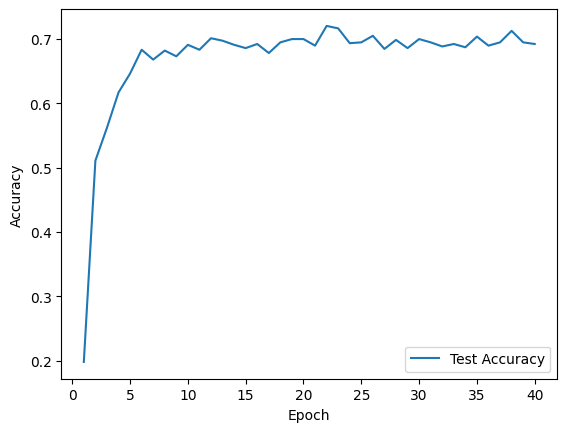

In [19]:
# Train early fusion model
print("Training Early Fusion Model:")
train_early_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=40)

Training Late Fusion Model:
Epoch 1/40 - Test Accuracy: 0.1788
Epoch 2/40 - Test Accuracy: 0.5006
Epoch 3/40 - Test Accuracy: 0.6015
Epoch 4/40 - Test Accuracy: 0.6373
Epoch 5/40 - Test Accuracy: 0.6769
Epoch 6/40 - Test Accuracy: 0.6973
Epoch 7/40 - Test Accuracy: 0.6616
Epoch 8/40 - Test Accuracy: 0.6858
Epoch 9/40 - Test Accuracy: 0.6871
Epoch 10/40 - Test Accuracy: 0.7050
Epoch 11/40 - Test Accuracy: 0.7050
Epoch 12/40 - Test Accuracy: 0.6986
Epoch 13/40 - Test Accuracy: 0.7024
Epoch 14/40 - Test Accuracy: 0.6986
Epoch 15/40 - Test Accuracy: 0.6986
Epoch 16/40 - Test Accuracy: 0.7088
Epoch 17/40 - Test Accuracy: 0.7075
Epoch 18/40 - Test Accuracy: 0.6999
Epoch 19/40 - Test Accuracy: 0.7126
Epoch 20/40 - Test Accuracy: 0.7190
Epoch 21/40 - Test Accuracy: 0.7011
Epoch 22/40 - Test Accuracy: 0.7114
Epoch 23/40 - Test Accuracy: 0.6922
Epoch 24/40 - Test Accuracy: 0.7152
Epoch 25/40 - Test Accuracy: 0.6986
Epoch 26/40 - Test Accuracy: 0.7101
Epoch 27/40 - Test Accuracy: 0.7126
Epoch 28/

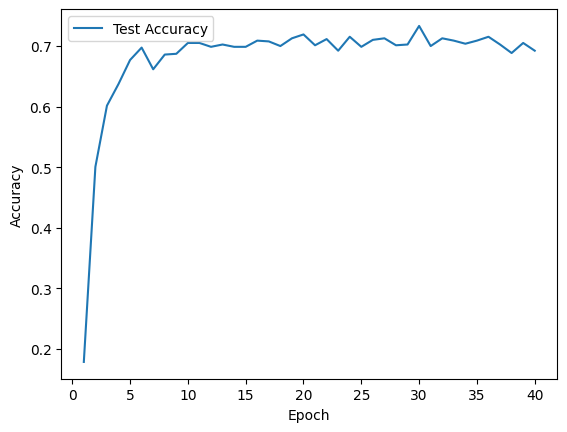

In [20]:
# Train late fusion model
print("Training Late Fusion Model:")
train_late_fusion(train_loader, test_loader, text_input_size, image_input_size, output_size, num_epochs=40)